In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

import re
from sklearn.externals import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords


import warnings
%matplotlib inline

warnings.filterwarnings('ignore');

In [178]:
datatypes = {
    "Unnamed: 0":"int64",
    "country":"object",
    "description":"object",
    "designation":"object",
    "points":"int64",
    "price":"float64",
    "province":"object",
    "region_1":"object",
    "region_2":"object",
    "taster_name":"object",
    "taster_twitter_handle":"object",
    "title":"object",
    "variety":"object",
    "winery":"object"
}

In [179]:
df = pd.read_csv('../data_root/raw/wine_dataset.csv',dtype=datatypes)

## Utilities functions

In [180]:
stopWords = set(stopwords.words('english'))

def dependent_column_to_categorical(df,column):
    '''
    https://www.wine-searcher.com/wine-scores
    '''
    if (df[column] >= 80) & (df[column] <= 84):
        return "Good"
    elif (df[column] >= 85) & (df[column] <= 89):
        return "Very good"
    elif (df[column] >= 90) & (df[column] <= 94):
        return "Outstanding"
    elif (df[column] >= 95) & (df[column] <= 100):
        return "Classic"
    
def processing(df,col):
    '''Chain of transformations for initially processing dataframe
    
        1. Change dependent variable to categorical
        
        2. Convert description column to lowercase and remove punctuations
        
        3. Get total length of sentences from 2
        
        4. Get total number of words
        
        5. Get total number of non-stop words
        
        6. Get the average word length
        
       Parameters
       ----------
       df: dataframe on which transformation is done
       
       col: The independent column. In our case, a column with text
    '''
    if df['points'].dtype == 'int64':
        df["points"] = df.apply(lambda df:dependent_column_to_categorical(df,"points"),
                                          axis = 1)

    df[f'{col}_processed'] = df[col].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    
    df['length'] = df[f'{col}_processed'].apply(lambda x: len(x))
    
    df['words'] = df[f'{col}_processed'].apply(lambda x: len(x.split(' ')))
    
    df['words_not_stopword'] = df[f'{col}_processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    
    df['avg_word_length'] = df[f'{col}_processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopWords]) if len([len(t) for t in x.split(' ') if t not in stopWords]) > 0 else 0)
    
    return(df)


class TextSelector(BaseEstimator, TransformerMixin):
    """Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    
    Parameters
    ---------
    key: Name of text column on which transformation is done
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

    
class NumberSelector(BaseEstimator, TransformerMixin):
    """Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    
    Parameters
    ---------
    key: Name of numeric column on which transformation is done
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

In [181]:
df_keep = df[['description','points']].loc[:]

df_keep.head(2)

,description,points
0,"Fragrances suggest hay, crushed tomato vine an...",90
1,"Packed with fruit and crisp acidity, this is a...",87


In [182]:
df_keep = processing(df_keep,col="description")

df_keep.head(2)

,description,points,description_processed,length,words,words_not_stopword,avg_word_length
0,"Fragrances suggest hay, crushed tomato vine an...",Outstanding,fragrances suggest hay crushed tomato vine and...,215,31,25,6.640000
1,"Packed with fruit and crisp acidity, this is a...",Very good,packed with fruit and crisp acidity this is a ...,168,30,18,5.944444


In [183]:
dependent = 'points'

engineered_features = [f for f in df_keep.columns.values if f not in ['description','points']]
numeric_features = [numeric for numeric in df_keep.columns.values if numeric not in ['description','points','description_processed']]

In [184]:
X_train, X_test, y_train, y_test = train_test_split(df_keep[engineered_features], df_keep[dependent], test_size=0.2, random_state=42)
X_train.head(2)

,description_processed,length,words,words_not_stopword,avg_word_length
9254,this opens with aromas of wet leaves forest fl...,235,40,27,5.962963
1561,there is no lack of dark smoky flavors in this...,329,60,33,5.727273


## Let's create scikit-learn pipelines for each columns

In [185]:
description = Pipeline([
                ('selector', TextSelector(key='description_processed')),
                ('tfidf', TfidfVectorizer( stop_words='english'))
            ])

description.fit_transform(X_train)

<8000x12486 sparse matrix of type '<class 'numpy.float64'>'
	with 186516 stored elements in Compressed Sparse Row format>

### Pipeline for feature scaling all numeric columns

In [186]:
length =  Pipeline([
                ('selector', NumberSelector(key='length')),
                ('standard', StandardScaler())
            ])

words =  Pipeline([
                ('selector', NumberSelector(key='words')),
                ('standard', StandardScaler())
            ])

words_not_stopword =  Pipeline([
                ('selector', NumberSelector(key='words_not_stopword')),
                ('standard', StandardScaler())
            ])

avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())
            ])

### Let's now join all our processing pipelines

In [187]:
feats = FeatureUnion([('description', description), 
                      ('length', length),
                      ('words', words),
                      ('words_not_stopword', words_not_stopword),
                      ('avg_word_length', avg_word_length)])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<8000x12490 sparse matrix of type '<class 'numpy.float64'>'
	with 218516 stored elements in Compressed Sparse Row format>

### Time to fit some algorithms to our preprocessed pipeline and choose the best one

In [188]:
classifiers = {
    "RandomForestClassifier":RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1,random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression":LogisticRegression(random_state=42),
    "SGDClassifier":SGDClassifier(random_state=42)
}




for name,classifier in classifiers.items():
    pipeline = Pipeline([
    ('features',feats),
    ('classifier', classifier),
])

    pipeline.fit(X_train, y_train)
    
    preds = pipeline.predict(X_test)
    
    print(f"{name} average prediction accuracy is {pipeline.score(X_test,y_test)}")
    

RandomForestClassifier average prediction accuracy is 0.673
AdaBoostClassifier average prediction accuracy is 0.6125
KNeighborsClassifier average prediction accuracy is 0.6225
LogisticRegression average prediction accuracy is 0.7105
SGDClassifier average prediction accuracy is 0.6915


### Let's tune for LogisticRegression to find the best hyper parameters

In [189]:
lr_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_pipeline.fit(X_train, y_train)

preds = lr_pipeline.predict(X_test)
lr_pipeline.score(X_test,y_test)

0.7105

### We'll now use GridSearch and a 5-fold cross validation to find the optimal hyper-parameters

In [190]:
param_grid = {
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']
}

CV = GridSearchCV(lr_pipeline, param_grid, n_jobs=-1,cv=5)

CV.fit(X_train,y_train)

CV.refit

preds = CV.predict(X_test)
CV.score(X_test,y_test)

0.716

### Serializing the model

In [191]:
joblib.dump(lr_pipeline,'lr_model.pkl')

['lr_model.pkl']

## Evaluation of model

#### Logistic regression report

In [192]:
report_dict_lr = classification_report(y_test, preds, output_dict=True)
report_dict_lr_df = pd.DataFrame(report_dict_lr)
report_dict_lr_df

,Classic,Good,Outstanding,Very good,micro avg,macro avg,weighted avg
f1-score,0.0,0.314516,0.728136,0.765311,0.716,0.451991,0.692183
precision,0.0,0.750000,0.724696,0.709196,0.716,0.545973,0.704700
recall,0.0,0.198980,0.731608,0.831068,0.716,0.440414,0.716000
support,40.0,196.000000,734.000000,1030.000000,2000.000,2000.000000,2000.000000


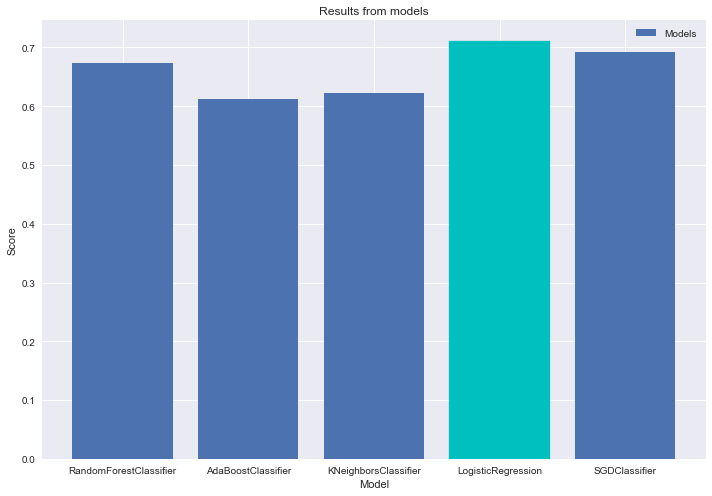

In [193]:

fig, ax = plt.subplots(figsize=(10,7))

plt.style.use("seaborn")

X = [
    'RandomForestClassifier','AdaBoostClassifier','KNeighborsClassifier'
    ,'LogisticRegression','SGDClassifier']

y = [
0.673,
0.6125,
0.6225,
0.7105,
0.6915
]

plot = plt.bar(X, y,label='Models')
plot[3].set_color('c')

plt.legend()

plt.title("Results from models")
plt.xlabel("Model")
plt.ylabel("Score")

plt.tight_layout()

plt.show()